# Notebook to define ensemble for production, cm level
Version developed for ViEWS monthly updates: Fatalities002
## Including ensemble weighting

This notebook defines the ensemble used for production: selects a set of pre-trained models, retrieves and calibrates them, computes weights, and computes and stores the ensemble model predictions.

Models are stored in model storage and most of them specified in the notebook fat_cm_constituentmodels

The notebook draws on the following files in this repository:

Script file: 
    Ensembling.py
    FetchData.py

Lists of models:
    ModelList_cm_{dev_id}.csv (not yet functional)
    List of pickles at local directory (will rewrite to drop dependence on this)

In [1]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
# Views 3
from viewser.operations import fetch
from viewser import Queryset, Column
import views_runs
from views_partitioning import data_partitioner, legacy
from stepshift import views
import views_dataviz
from views_runs import storage, ModelMetadata
from views_runs.storage import store, retrieve, fetch_metadata
from views_forecasts.extensions import *
# Other packages
import pickle as pkl

In [2]:
# Packages from this repository, Tools folder
import sys
sys.path.append('../')
sys.path.append('../Tools')
sys.path.append('../Intermediates')

from Ensembling import CalibratePredictions, RetrieveStoredPredictions, mean_sd_calibrated, gam_calibrated
from FetchData import FetchData, RetrieveFromList
from ViewsEstimators import *


/Users/havardhegre/anaconda3/envs/viewser/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
# Common parameters:

dev_id = 'Fatalities002'
run_id = 'Fatalities002'
EndOfHistory = 509
RunGeneticAlgo = True
level = 'cm'

steps = [*range(1, 36+1, 1)] # Which steps to train and predict for

fi_steps = [1,3,6,12,36]
# Specifying partitions

calib_partitioner_dict = {"train":(121,396),"predict":(397,444)}
test_partitioner_dict = {"train":(121,444),"predict":(445,492)}
future_partitioner_dict = {"train":(121,492),"predict":(493,504)}
calib_partitioner =  views_runs.DataPartitioner({"calib":calib_partitioner_dict})
test_partitioner =  views_runs.DataPartitioner({"test":test_partitioner_dict})
future_partitioner =  views_runs.DataPartitioner({"future":future_partitioner_dict})

Mydropbox = '/Users/havardhegre/Dropbox (ViEWS)/ViEWS/'
overleafpath = '/Users/havardhegre/Dropbox (ViEWS)/Apps/Overleaf/ViEWS predicting fatalities/Tables/'
localpath = '/Users/havardhegre/Pickles/'



In [4]:
from ModelDefinitions import DefineEnsembleModels

ModelList = DefineEnsembleModels(level)
    
i = 0
for model in ModelList:
    print(i, model['modelname'], model['data_train'])
    i = i + 1

0 fatalities002_baseline_rf baseline002
1 fat_conflicthistory_rf conflict_ln
2 fat_conflicthistory_gbm conflict_ln
3 fat_conflicthistory_hurdle_lgb conflict_ln
4 fat_conflicthistory_long_xgb conflictlong_ln
5 fat_vdem_hurdle_xgb vdem_short
6 fat_wdi_rf wdi_short
7 fatalities002_topics_rf topics_002
8 fat_topics_rf topics_short
9 fatalities002_topics_hurdle_lgb topics_002
10 fat_topics_histgbm topics_short
11 fat_broad_xgb broad
12 fatalities002_greatest_hits_hurdle_rf gh
13 fat_hh20_hurdle_rf hh20
14 fat_hh20_hurdle_xgb hh20
15 fat_hh20_hurdle_lgb hh20
16 fat_all_pca3_xgb pca_all
17 fatalities002_aquastat_rf aquastat
18 fatalities002_faostat_rf faostat
19 fatalities002_faoprices_rf faoprices
20 fatalities002_imfweo_rf imfweo
21 fat_hh20_Markov_glm hh20
22 fat_hh20_Markov_rf hh20


# Retrieve and calibrate predictions

In [5]:
# Retrieving the predictions for calibration and test partitions
# The ModelList contains the predictions organized by model

ModelList = RetrieveStoredPredictions(ModelList, steps, EndOfHistory, dev_id)

ModelList = CalibratePredictions(ModelList, EndOfHistory, steps)

0 fatalities002_baseline_rf
pr_46_cm_fatalities002_baseline_rf_calib.parquet
pr_46_cm_fatalities002_baseline_rf_test.parquet
1 fat_conflicthistory_rf
pr_46_cm_fat_conflicthistory_rf_calib.parquet
pr_46_cm_fat_conflicthistory_rf_test.parquet
2 fat_conflicthistory_gbm
pr_46_cm_fat_conflicthistory_gbm_calib.parquet
pr_46_cm_fat_conflicthistory_gbm_test.parquet
3 fat_conflicthistory_hurdle_lgb
pr_46_cm_fat_conflicthistory_hurdle_lgb_calib.parquet
pr_46_cm_fat_conflicthistory_hurdle_lgb_test.parquet
4 fat_conflicthistory_long_xgb
pr_46_cm_fat_conflicthistory_long_xgb_calib.parquet
pr_46_cm_fat_conflicthistory_long_xgb_test.parquet
5 fat_vdem_hurdle_xgb
pr_46_cm_fat_vdem_hurdle_xgb_calib.parquet
pr_46_cm_fat_vdem_hurdle_xgb_test.parquet
6 fat_wdi_rf
pr_46_cm_fat_wdi_rf_calib.parquet
pr_46_cm_fat_wdi_rf_test.parquet
7 fatalities002_topics_rf
pr_46_cm_fatalities002_topics_rf_calib.parquet
pr_46_cm_fatalities002_topics_rf_test.parquet
8 fat_topics_rf
pr_46_cm_fat_topics_rf_calib.parquet
pr_46_c

# Genetic algorithm

In [6]:
from joblib import Parallel, delayed, cpu_count
from functools import partial
from genetic2 import *

from pathlib import Path

def make_run_from_step (
    step,
    e_set,
    df_name = 'calib_df_calibrated', 
    target = 'ln_ged_sb_dep',
    population_count = 100,
    initial_population = None,
    base_genes = np.array([0,1]),
    number_of_generations = 500
):
    """
    step : step you want as an int,
    ensemble_set : structure of the EnsembleList type,
    target = Y in prediction,
    df_name = name of the df in the ensemble set you want.
    """
    
    df_step = f'step_pred_{step}'
    
    try: 
        del aggregate_df
    except NameError:
        pass 
    
    for i_ens in ModelList:
        try:
            #Join the step from the model into the ensemble df if it exists.
            aggregate_df = aggregate_df.join(i_ens[df_name][[df_step]], rsuffix=f'_{i_ens["modelname"]}')
        except NameError:
            #If the ensemble df does not exist create it and include the target.
            aggregate_df = i_ens[df_name][[target,df_step]].copy()
            aggregate_df = aggregate_df.rename(columns = {df_step : f'{df_step}_{i_ens["modelname"]}'})
    
    aggregate_df = aggregate_df.dropna()
    aggregate_df = aggregate_df[aggregate_df.columns[~aggregate_df.columns.str.contains('ensemble')]]
    
    X = aggregate_df.copy(); del X[target]
    Y = aggregate_df[target]
    
    inst_mse = partial(weighted_mse_score, Y, X, mean_squared_error)
    if initial_population is None:
        population =  init_population_sum(population_count,base_genes,X.shape[1],0.5,3)
    else: 
        population = initial_population
    
    from genetic2 import temp_file_name
    import os
    Path('./exploration_pickle/').mkdir(parents=True, exist_ok=True) 
    pd.DataFrame({'step':[step], 'memoization_id':[temp_file_name]}).to_csv(f'exploration_pickle/id_{temp_file_name}.csv', index=False)
    
    generation = genetic_algorithm(population, 
                                   inst_mse, 
                                   base_genes, 
                                   f_thres=None, 
                                   ngen=number_of_generations, 
                                   pmut=0.2)
    return {'step':step, 'memoization_id':temp_file_name, 'generation':generation}
    

Refreshing


In [7]:
super_walrus_genes = np.array([0, 0.010, 0.015, 0.020, 0.025, 0.030, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.12, 0.14, 0.16, 0.18, 0.20, 0.25, 0.30])
nonlogged_genes = np.array([0, 0.02, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.9, 1, 1.1, 1.2, 1.5, 2.0])#, 1, 1.2, 1.4, 1.6, 1.8, 2.0, 2.5])
print(len(nonlogged_genes))
steps_to_optimize = [1,2,3,4,6,9,12,15,18,24,30,36]

24


In [8]:
filled_function = partial(make_run_from_step, 
    e_set = ModelList,
    df_name = 'predictions_calib_df', # Non-logged version
    target = 'ln_ged_sb_dep',
    population_count = 100,
    initial_population = None,
    base_genes = super_walrus_genes,
    number_of_generations = 100
)



In [9]:
cpus = cpu_count()-4 if cpu_count()>2 else 1
cpus - len(steps_to_optimize)

0

In [10]:
# 15 models, 24 genes, 12 steps, 100 generations takes 41 minutes
if RunGeneticAlgo:

    ct = datetime.now()
    print('Estimating genetic weights, current time:', ct)
    generations = Parallel(n_jobs=cpus)(delayed(filled_function)(i) for i in steps_to_optimize)
    ct = datetime.now()
    print('Done estimating weights, current time:', ct)
    with open('exploration_pickle/full_gen.pickle', 'wb') as handle:
        pkl.dump(generations, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    picklename = 'exploration_pickle/full_gen.pickle'
    generations = pkl.load( open (picklename, "rb") )
    

Estimating genetic weights, current time: 2022-06-28 09:49:21.978217
Done estimating weights, current time: 2022-06-28 10:05:59.507816


In [11]:
# Print the memoization id's so that you can explore the training process in the visualizer
for i in generations:
    print (i['step'], i['memoization_id'])

1 f50a5add548c4fa5b07c3fc717b854e7
2 f5efabc3a2354990a824ea6901a5c03d
3 247cfd26fbe84d239083caa3e9759138
4 77f759bcc48d440db812c0a118223afa
6 603845acb9414e3c94224dc31060b591
9 d2b9b15da98e4f8fb97ce3aec5f0cfa7
12 dd4013cc9b2042368c808829448af72c
15 dcceb2b9acd04fcaab19e77d8edffe68
18 37d4128a510f4fc79489ae70a5ed5839
24 53922ab37d144e059a335614eb4bae87
30 b8fba97bad854d6ab6603bab1f3732d1
36 7a54883498e24855966374477afa4fec


In [12]:
# Fetch the best organism.
GeneticAlgoResult = []
for gen in generations:
    print ('\nStep: ',gen['step'],'\n','*'*24,'\n')
    print (gen['generation'][0])
    #The best is always the top organism. You can get the top 20 by slicing gen['generation'][0:20] and so on
    linedict = {
        'Org': gen['generation'][0][0],
        'Fitness': gen['generation'][0][1],
        'Step': gen['step']
    }
    GeneticAlgoResult.append(linedict)
print(GeneticAlgoResult)


Step:  1 
 ************************ 

([0.01, 0.12, 0.16, 0.14, 0.0, 0.015, 0.0, 0.0, 0.015, 0.025, 0.07, 0.08, 0.04, 0.015, 0.0, 0.0, 0.0, 0.025, 0.01, 0.07, 0.04, 0.25, 0.01], 27.43998483030015)

Step:  2 
 ************************ 

([0.025, 0.1, 0.12, 0.16, 0.02, 0.0, 0.01, 0.0, 0.025, 0.01, 0.0, 0.18, 0.0, 0.0, 0.0, 0.0, 0.01, 0.04, 0.02, 0.08, 0.03, 0.25, 0.04], 17.309261130223454)

Step:  3 
 ************************ 

([0.0, 0.16, 0.2, 0.02, 0.01, 0.0, 0.0, 0.03, 0.01, 0.0, 0.08, 0.18, 0.025, 0.0, 0.0, 0.0, 0.0, 0.04, 0.0, 0.05, 0.025, 0.16, 0.16], 12.794942595030559)

Step:  4 
 ************************ 

([0.01, 0.16, 0.12, 0.16, 0.0, 0.015, 0.0, 0.02, 0.02, 0.0, 0.08, 0.16, 0.0, 0.0, 0.0, 0.0, 0.0, 0.025, 0.01, 0.04, 0.02, 0.12, 0.2], 11.868430357378626)

Step:  6 
 ************************ 

([0.015, 0.2, 0.1, 0.12, 0.015, 0.0, 0.0, 0.02, 0.01, 0.01, 0.025, 0.025, 0.0, 0.0, 0.01, 0.015, 0.03, 0.02, 0.0, 0.05, 0.01, 0.3, 0.2], 10.005592338505377)

Step:  9 
 ***************

# Assignment of the genetic weights

In [13]:
# Reading from GeneticAlgoResult:
w_step = [None] * 37
for line in GeneticAlgoResult:
    w_step[line['Step']] = line['Org']
i=2
for i in [1,2,3,6,9,12,18,24,30,36]:
    w_step[i]
    print(sum(w_step[i]))




1.0950000000000002
1.12
1.1500000000000001
1.1750000000000003
1.1700000000000002
1.1400000000000003
1.195
1.245
1.3
1.26


In [14]:
# Linear interpolation of weights:
print(steps_to_optimize)
WeightMatrix = [None] * 37
modelnames = []
for model in ModelList: 
    modelnames.append(model['modelname'])
for step in steps:
    if step in steps_to_optimize:
#        print(step, 'is optimized')
        WeightMatrix[step] = w_step[step]
    else:
        WeightMatrix[step] = np.nan * len(w_step[1])


[1, 2, 3, 4, 6, 9, 12, 15, 18, 24, 30, 36]


In [15]:
StepAssigner = [1,2,3,4,4,6,6,9,9,9,12,12,12,15,15,15,18,18,18,18,18,24,24,24,24,24,24,30,30,30,30,30,30,36,36,36]
WeightMatrix = [None] * 37

stepcols = ['ln_ged_sb_dep']
for step in steps:
    stepcols.append('step_pred_' + str(step))
modelnames = []
for model in ModelList: 
    modelnames.append(model['modelname'])

for step in steps:
#    print('Step',step,'assigned',StepAssigner[step-1])
    WeightMatrix[step] = w_step[StepAssigner[step-1]]
wmt = np.array(WeightMatrix[1:]).T
weights_df = pd.DataFrame(wmt,columns=stepcols[1:],index=modelnames)
weights_df

,step_pred_1,step_pred_2,step_pred_3,step_pred_4,step_pred_5,step_pred_6,step_pred_7,step_pred_8,step_pred_9,step_pred_10,...,step_pred_27,step_pred_28,step_pred_29,step_pred_30,step_pred_31,step_pred_32,step_pred_33,step_pred_34,step_pred_35,step_pred_36
fatalities002_baseline_rf,0.010,0.025,0.000,0.010,0.010,0.015,0.015,0.025,0.025,0.025,...,0.020,0.040,0.040,0.040,0.040,0.040,0.040,0.100,0.100,0.100
fat_conflicthistory_rf,0.120,0.100,0.160,0.160,0.160,0.200,0.200,0.120,0.120,0.120,...,0.070,0.015,0.015,0.015,0.015,0.015,0.015,0.010,0.010,0.010
fat_conflicthistory_gbm,0.160,0.120,0.200,0.120,0.120,0.100,0.100,0.090,0.090,0.090,...,0.300,0.300,0.300,0.300,0.300,0.300,0.300,0.250,0.250,0.250
fat_conflicthistory_hurdle_lgb,0.140,0.160,0.020,0.160,0.160,0.120,0.120,0.200,0.200,0.200,...,0.120,0.000,0.000,0.000,0.000,0.000,0.000,0.020,0.020,0.020
fat_conflicthistory_long_xgb,0.000,0.020,0.010,0.000,0.000,0.015,0.015,0.050,0.050,0.050,...,0.010,0.015,0.015,0.015,0.015,0.015,0.015,0.050,0.050,0.050
fat_vdem_hurdle_xgb,0.015,0.000,0.000,0.015,0.015,0.000,0.000,0.000,0.000,0.000,...,0.000,0.010,0.010,0.010,0.010,0.010,0.010,0.010,0.010,0.010
fat_wdi_rf,0.000,0.010,0.000,0.000,0.000,0.000,0.000,0.010,0.010,0.010,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
fatalities002_topics_rf,0.000,0.000,0.030,0.020,0.020,0.020,0.020,0.010,0.010,0.010,...,0.015,0.000,0.000,0.000,0.000,0.000,0.000,0.010,0.010,0.010
fat_topics_rf,0.015,0.025,0.010,0.020,0.020,0.010,0.010,0.010,0.010,0.010,...,0.140,0.140,0.140,0.140,0.140,0.140,0.140,0.160,0.160,0.160
fatalities002_topics_hurdle_lgb,0.025,0.010,0.000,0.000,0.000,0.010,0.010,0.000,0.000,0.000,...,0.070,0.200,0.200,0.200,0.200,0.200,0.200,0.000,0.000,0.000


In [16]:
# Interpolated weights
i_weights_df = weights_df.copy()
for step in steps:
    col = 'step_pred_' + str(step)
    if step == 5:
        prestepcol = 'step_pred_' + str(step-1)
        
        poststepcol = 'step_pred_' + str(step+1)
        i_weights_df[col] = (i_weights_df[prestepcol] + i_weights_df[poststepcol]) / 2
    if step == 7 or step == 10 or step == 13 or step == 16:
        prestepcol = 'step_pred_' + str(step-1)
        poststepcol = 'step_pred_' + str(step+2)
        i_weights_df[col] = ((i_weights_df[prestepcol]*2) + (i_weights_df[poststepcol]*1)) / 3
    if step == 8 or step == 11 or step == 14 or step == 17:
        prestepcol = 'step_pred_' + str(step-2)
        poststepcol = 'step_pred_' + str(step+1)
        i_weights_df[col] = ((i_weights_df[prestepcol]*1) + (i_weights_df[poststepcol]*2)) / 3
    if step == 19 or step == 25 or step == 31:
        prestepcol = 'step_pred_' + str(step-1)
        poststepcol = 'step_pred_' + str(step+5)
        i_weights_df[col] = ((i_weights_df[prestepcol]*5) + (i_weights_df[poststepcol]*1)) / 6
    if step == 20 or step == 26 or step == 32:
        prestepcol = 'step_pred_' + str(step-2)
        poststepcol = 'step_pred_' + str(step+3)
        i_weights_df[col] = ((i_weights_df[prestepcol]*4) + (i_weights_df[poststepcol]*2)) / 6
    if step == 21 or step == 27 or step == 33:
        prestepcol = 'step_pred_' + str(step-3)
        poststepcol = 'step_pred_' + str(step+3)
        i_weights_df[col] = ((i_weights_df[prestepcol]*3) + (i_weights_df[poststepcol]*3)) / 6
    if step == 22 or step == 28 or step == 34:
        prestepcol = 'step_pred_' + str(step-4)
        poststepcol = 'step_pred_' + str(step+2)
        i_weights_df[col] = ((i_weights_df[prestepcol]*2) + (i_weights_df[poststepcol]*4)) / 6
    if step == 23 or step == 29 or step == 35:
        prestepcol = 'step_pred_' + str(step-5)
        poststepcol = 'step_pred_' + str(step+1)
        i_weights_df[col] = ((i_weights_df[prestepcol]*1) + (i_weights_df[poststepcol]*5)) / 6
        
print(steps_to_optimize)
# Export weights 
i_weights_df.to_csv('../Intermediates/GeneticWeights.csv')
i_weights_df
# Save the weights dfs
dflist = [
    (i_weights_df,'i_weights_df'), 
]

path = Mydropbox + 'Projects/PredictingFatalities/MSEs/'
for df in dflist:
    filename = path + df[1] + '.csv'
    df[0].to_csv(filename)
    

[1, 2, 3, 4, 6, 9, 12, 15, 18, 24, 30, 36]


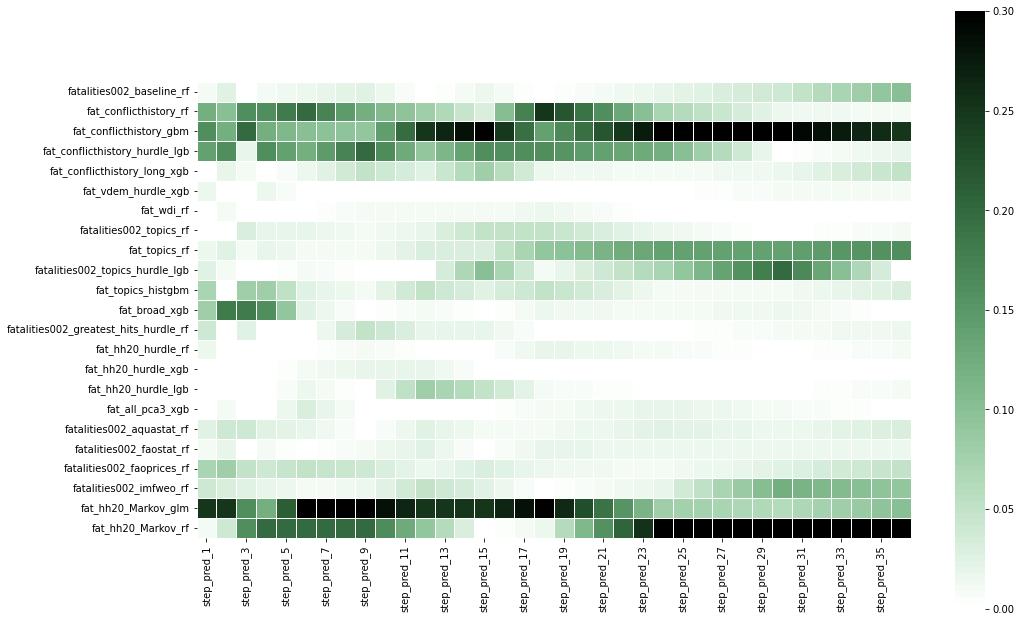

In [17]:
import seaborn as sns
palette = 'vlag'
palette = sns.color_palette('BrBG',n_colors=50)
palette = sns.cubehelix_palette(start=2, rot=0, dark=0, light=1, n_colors=100)

fig, ax =plt.subplots(1,figsize=(16,11))
ax = sns.heatmap(i_weights_df, xticklabels=2, linewidths=.5, cmap=palette,square=True)
filename = overleafpath + 'genetic_weights.png'
plt.savefig(filename, dpi=300)

In [18]:
# Constructing dfs to hold the predictions
# A list of dictionaries organizing predictions and information as one step per entry,
# including a dataframe for each step with one column per prediction model
StepEnsembles = []
for col in stepcols[1:]:  # Use the baseline as template to construct object
    Step_prediction = {
        'step_pred': col,
        'df_calib': pd.DataFrame(ModelList[0]['calib_df_calibrated']['ln_ged_sb_dep']), 
        'df_test': pd.DataFrame(ModelList[0]['test_df_calibrated']['ln_ged_sb_dep']),
        'ensembles_calib': pd.DataFrame(ModelList[0]['calib_df_calibrated']['ln_ged_sb_dep']),
        'ensembles_test': pd.DataFrame(ModelList[0]['test_df_calibrated']['ln_ged_sb_dep'])
    }
    for model in ModelList:
        modelname = model['modelname']
        Step_prediction['df_calib'][modelname] = model['calib_df_calibrated'][col]
        Step_prediction['df_test'][modelname] = model['test_df_calibrated'][col]
    StepEnsembles.append(Step_prediction)

# Calculating unweighted average ensembles
i = 0
for col in stepcols[1:]:
    # Unweighted average
    StepEnsembles[i]['ensembles_test']['unweighted_average'] = StepEnsembles[i]['df_test'].drop('ln_ged_sb_dep', axis=1).mean(axis=1)
    StepEnsembles[i]['ensembles_calib'].loc['unweighted_average'] = StepEnsembles[i]['df_calib'].drop('ln_ged_sb_dep', axis=1).mean(axis=1)
    i = i + 1


In [19]:
StepEnsembles[0]['ensembles_test']['unweighted_average']

month_id  country_id
445       1             0.010893
          2             0.009052
          3             0.011423
          4             0.023953
          5             0.012323
                          ...   
492       242           0.946276
          243           0.019181
          244           0.028352
          245           1.069212
          246           1.883817
Name: unweighted_average, Length: 9168, dtype: float64

In [20]:

# Calculating weighted average ensembles
# Based on the weights_df dataframe filled with Mihai's weights above

def ensemble_predictions(yhats, weights):
    # make predictions
    yhats = np.array(yhats)
    # weighted sum across ensemble members
    result = np.dot(weights,yhats)
    return result

# normalize a vector to have unit norm
def normalize(weights):
    # calculate l1 vector norm
    result = norm(weights, 1)
    # check for a vector of all zeros
    if result == 0.0:
        return weights
    # return normalized vector (unit norm)
    return weights / result

i = 0
for col in stepcols[1:]:
    # Unweighted average
    df_calib = StepEnsembles[i]['df_calib'].drop('ln_ged_sb_dep', axis=1)
    df_test = StepEnsembles[i]['df_test'].drop('ln_ged_sb_dep', axis=1)
    StepEnsembles[i]['ensembles_calib']['weighted_average'] = (df_calib*i_weights_df[col]).sum(axis=1)
    StepEnsembles[i]['ensembles_test']['weighted_average'] =  (df_test*i_weights_df[col]).sum(axis=1)
    i = i + 1

In [21]:
# Reshape the ensemble predictions
EnsembleList = []
genetic = {
        'modelname': 'ensemble_genetic',
        'algorithm': '',
        'depvar': "ln_ged_sb_dep",
        'calib_df_calibrated': ModelList[0]['calib_df_calibrated'].copy(),
        'test_df_calibrated': ModelList[0]['test_df_calibrated'].copy(),
    }    

for step in StepEnsembles:
    colname = step['step_pred']
    print(colname)
    genetic['calib_df_calibrated'][colname] = step['ensembles_calib']['weighted_average']
    genetic['test_df_calibrated'][colname] = step['ensembles_test']['weighted_average']

EnsembleList.append(genetic)


step_pred_1
step_pred_2
step_pred_3
step_pred_4
step_pred_5
step_pred_6
step_pred_7
step_pred_8
step_pred_9
step_pred_10
step_pred_11
step_pred_12
step_pred_13
step_pred_14
step_pred_15
step_pred_16
step_pred_17
step_pred_18
step_pred_19
step_pred_20
step_pred_21
step_pred_22
step_pred_23
step_pred_24
step_pred_25
step_pred_26
step_pred_27
step_pred_28
step_pred_29
step_pred_30
step_pred_31
step_pred_32
step_pred_33
step_pred_34
step_pred_35
step_pred_36


In [22]:
# Save ensemble predictions
predstore_calib = level +  '_' + genetic['modelname'] + '_calib'
genetic['calib_df_calibrated'].forecasts.set_run(run_id)
genetic['calib_df_calibrated'].forecasts.to_store(name=predstore_calib, overwrite = True)
predstore_test = level +  '_' + genetic['modelname'] + '_test'
genetic['test_df_calibrated'].forecasts.set_run(run_id)
genetic['test_df_calibrated'].forecasts.to_store(name=predstore_test, overwrite = True)

In [ ]:
# See which genetic ensembles are in prediction storage
ViewsMetadata().with_name('genetic').fetch()